In [2]:
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import patches


import scipy.ndimage as ndimage
import skimage
from skimage.transform import hough_circle, hough_circle_peaks

import astropy.wcs
from astropy.coordinates import EarthLocation
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel, Gaussian1DKernel

import sunpy
import sunpy.map
import sunpy.coordinates

import glob
import rawpy

from PIL import Image

import exifread

import sys
sys.executable


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Friday, 22. September 2017 01:33AM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 0.8.1
SunPy_git : 3ac1d0ba6db3bf753cf524cd56fedc24530b238e
OS: Mac OS X 10.12.6 (i386)


###########
 Required Libraries 
###########
Python: 3.6.2
NumPy: 1.13.1
SciPy: 0.19.1
matplotlib: 2.0.2
Astropy: 2.0.1
Pandas: 0.20.3


###########
 Recommended Libraries 
###########
beautifulsoup: 4.6.0
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.13
Requests: 2.18.4


In [4]:
infiles = glob.glob('../Igor/D500/*NEF')

f='DSC_0076.jpg'

Replace the following with your photo filename. Here we are using an eclipse photo originally taken by Henke Bril taken in Salloum, Egypt on March 29, 2006. We've hacked the EXIF info to make it seem like it was taken for this eclipse. We will update this with a real 2017 Eclipse photo as soon as we have one!

In [5]:
#f = '../sample-photos/total_solar_eclipse2017.jpg'

f = '0061778862638115218146806135726482471400617777427003177088425708_jpg_2017_08_21_11_38_43_1240_731.jpg'  #Hugh's image
#f = '../Van/IMG_1382.CR2'  #Van image
#f = '../Camera_raw/DSC_0076.NEF'  #JCMO image
#f='../../../../Dropbox/Occultation/Braxton_Collier/Eclipse Photos/IMG_2172.JPG'

## First let's try to get some metadata from the file

In [6]:
tags = exifread.process_file(open(f, 'rb'))

tags

{'EXIF ApertureValue': (0x9202) Ratio=7892/3469 @ 636,
 'EXIF BrightnessValue': (0x9203) Signed Ratio=3504/18185 @ 644,
 'EXIF ColorSpace': (0xA001) Short=sRGB @ 432,
 'EXIF ComponentsConfiguration': (0x9101) Undefined=YCbCr @ 288,
 'EXIF DateTimeDigitized': (0x9004) ASCII=2017:08:21 11:38:43 @ 608,
 'EXIF DateTimeOriginal': (0x9003) ASCII=2017:08:21 11:38:43 @ 588,
 'EXIF ExifImageLength': (0xA003) Long=2448 @ 456,
 'EXIF ExifImageWidth': (0xA002) Long=3264 @ 444,
 'EXIF ExifVersion': (0x9000) Undefined=0221 @ 252,
 'EXIF ExposureBiasValue': (0x9204) Signed Ratio=0 @ 652,
 'EXIF ExposureMode': (0xA402) Short=Manual Exposure @ 492,
 'EXIF ExposureProgram': (0x8822) Short=Manual @ 228,
 'EXIF ExposureTime': (0x829A) Ratio=1/100 @ 572,
 'EXIF FNumber': (0x829D) Ratio=11/5 @ 580,
 'EXIF Flash': (0x9209) Short=Flash did not fire, compulsory flash mode @ 360,
 'EXIF FlashPixVersion': (0xA000) Undefined=0100 @ 420,
 'EXIF FocalLength': (0x920A) Ratio=83/20 @ 660,
 'EXIF FocalLengthIn35mmFilm

In [7]:
# the following functions will help us get GPS data from the EXIF data if it exists
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [8]:
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
else:
#    author_str = 'JC Martinez Oliveros' 
    author_str = 'Braxton Collier' 
    print("Author name of {0} found!".format(author_str))
    
if "EXIF DateTimeOriginal" in tags:
    datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(tags)

print(lat,lon)

if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))
else:
    #This is by hand for JCMO!
    lat = 44.892984
    lon = -123.020692
    gps = [lat, lon] * u.deg
    print("Using JCMO GPS default location of {0}, {1} found!".format(gps[0], gps[1]))    

Exposure time of 0.01 s found!
Author name of Braxton Collier found!
Image time of 2017-08-21 11:38:43 found!
Camera model of iPhone 5s found!
43.64792222222222 -109.936475
Found GPS location of 43.64792222222222 deg, -109.936475 deg found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [10]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'

#for Braxton Images!
from datetime import timedelta
d = timedelta(hours=6)

time = time + d  #<<< for Braxton
print(str(time))
time = time #datetime(2017, 8, 21, 17, 27, 13) # don't forget to convert your time to UTC!
#gps = [44.37197, -116.87393] * u.deg # latitude, longitude of Mann Creek, Idaho

2017-08-21 17:38:43


## Read in the image data

In [11]:
# read in the image and flip it so that it's correct
im_rgb = np.flipud(matplotlib.image.imread(f))

#raw = rawpy.imread(f)
im_rgb = np.flipud(raw.postprocess())

# remove color info
im = np.average(im_rgb, axis=2)

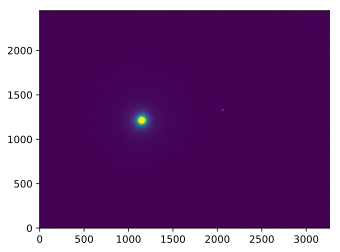

In [12]:
plt.imshow(im, origin='lower')
plt.savefig('fullimage.png',format='png')

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

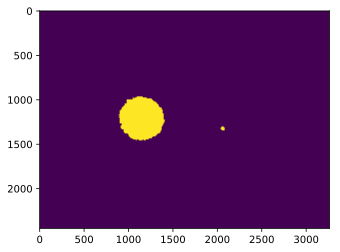

In [13]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

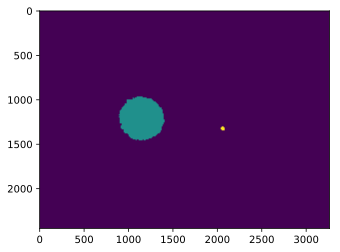

In [14]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

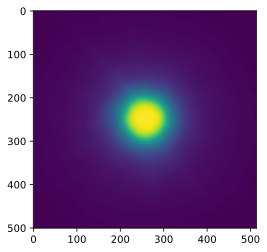

In [15]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

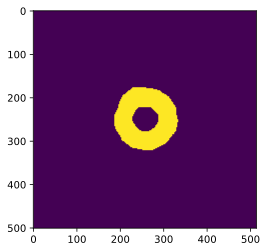

In [16]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [42]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
cy = cy - 110
cx = cx + 25
radii = radii - 100

print(cx, cy, radii)

[248] [257] [ 46.]


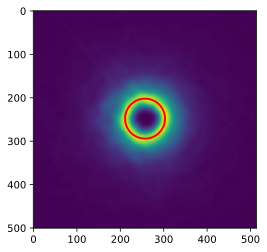

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

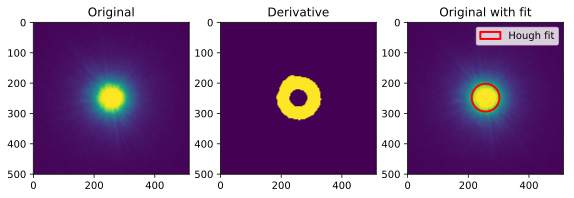

In [51]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_x, slice_y])
ax[0].set_title('Original')
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title('Derivative')
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2, label='Hough fit')
ax[2].imshow(im[slice_x, slice_y])
ax[2].add_patch(circ)
ax[2].set_title('Original with fit')
plt.legend()
plt.savefig('image_hough_fit_braxton.png', format='png', dpi=300)


Now let's check it with the original image

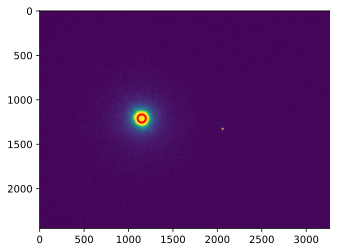

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fudge_shift_x = 0 * u.pix # update this in case the fit needs to be shifted in x
fudget_shift_y = 0 * u.pix # update this in case the fit needs to be shifted in y

#Van's Image
#fudge_shift_x = 33 * u.pix # update this in case the fit needs to be shifted in x
#fudget_shift_y =-100 * u.pix # update this in case the fit needs to be shifted in y

im_cx = (cx + slice_x.start) * u.pix + fudge_shift_x
im_cy = (cy + slice_y.start) * u.pix + fudget_shift_y
im_radius = radii * u.pix 
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im,vmax=70)
ax.add_patch(circ)
plt.show()

In [46]:
print(im_cx,im_cy)

[ 1210.] pix [ 1149.] pix


In [47]:
#im_rgb = np.flipud(matplotlib.image.imread(f))
#im = np.average(im_rgb, axis=2)

print(im_raw_y-y_circle_center)

NameError: name 'im_raw_y' is not defined

1149 1238 1210


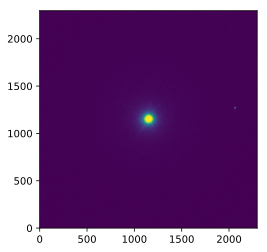

In [48]:
#Test 1
im_raw_y=np.shape(im)[0]
im_raw_x=np.shape(im)[1]

y_circle_center=int(im_cx.value[0])
x_circle_center=int(im_cy.value[0])

a=min([abs(im_raw_y-y_circle_center), y_circle_center,abs(im_raw_x-x_circle_center), x_circle_center])
print(a,abs(im_raw_y-y_circle_center), y_circle_center)

#a=1200
y_upp=y_circle_center+a
y_low=y_circle_center-a
x_low=x_circle_center-a
x_upp=x_circle_center+a

crop_image=im[y_low:y_upp-1,x_low:x_upp]
plt.imshow(crop_image, origin='lower')
#plt.savefig('image_orig_saida_code_braxton.png', format='png', dpi=1200)
plt.show()

im_raw_cy=np.shape(crop_image)[0]/2.
im_raw_cx=np.shape(crop_image)[1]/2.

In [49]:
def MGN_filter(data):
	w=[5,10,20,40,80,120]
	k=3.5 # Binarization incresed
	
	a0=data.min()
	a1=data.max()
	gamma=3.2
	h=1.7

	C_g=((data-a0)/(a1-a0))**(1./gamma)

	C_prima=[]
	print('complete 1')
	for i in w:
		print(i)
		gaussian_1D_kernel = Gaussian1DKernel(i)		
		
		#First convolve
		data_gauss_convolve1=[]
		for i in range(len(data)):
			data_gauss_convolve1.append(convolve(data[i], gaussian_1D_kernel))
		data_gauss_convolve2=np.transpose(np.array(data_gauss_convolve1))
		data_gauss_convolve3=[]
		for i in range(len(data_gauss_convolve2)):
			data_gauss_convolve3.append(convolve(data_gauss_convolve2[i], gaussian_1D_kernel))
		data_gauss_convolve_final=np.transpose(np.array(data_gauss_convolve3))

		diff_data_gauss_convolve=data-data_gauss_convolve_final		
		A=diff_data_gauss_convolve**2
	
		##Second convolve
		data_gauss_convolve1=[]	
		for i in range(len(A)):
			data_gauss_convolve1.append(convolve(A[i], gaussian_1D_kernel))
		data_gauss_convolve2=np.transpose(np.array(data_gauss_convolve1))
		data_gauss_convolve3=[]
		for i in range(len(data_gauss_convolve2)):
			data_gauss_convolve3.append(convolve(data_gauss_convolve2[i], gaussian_1D_kernel))
		diff_data_gauss_convolve_final=np.transpose(np.array(data_gauss_convolve3))

		
		sigma=np.sqrt(diff_data_gauss_convolve_final)		
		
		c=diff_data_gauss_convolve/sigma
		c_prima=np.arctan(k*c)
		C_prima.append(c_prima)

	print('complete 2')
	C_prima_mean=np.mean(np.array(C_prima),axis=0)

	final_data=h*C_g+C_prima_mean
	return final_data

complete 1
5
10
20
40
80
120
complete 2
255.0


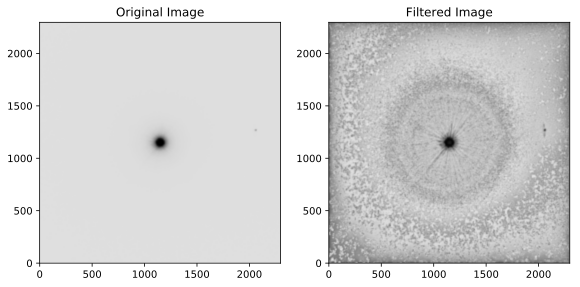

In [50]:
filter_new_image=MGN_filter(crop_image)
np.flipud(filter_new_image)

#plt.imshow(filter_new_image, interpolation='none', cmap=plt.cm.gray, origin='lower')
#plt.plot(im_raw_cx, im_raw_cy, 'ro')
#axes = plt.gca()
#axes.set_xlim([0,np.shape(crop_image)[1]])
#axes.set_ylim([0,np.shape(crop_image)[0]])

#plt.savefig('image_test_saida_code_76.png', format='png', dpi=1200)
#plt.show()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9.5, 6))
ax[0].imshow(crop_image, interpolation='bicubic', origin='lower', cmap=plt.cm.Greys,vmin=-70)
ax[0].set_title('Original Image')
ax[1].imshow(filter_new_image, interpolation='bicubic', cmap=plt.cm.Greys, origin='lower')
ax[1].set_title('Filtered Image')
plt.savefig('proposal_fig_braxton.pdf', format='pdf', dpi=300)

print(np.max(crop_image))

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [52]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

1.0115449495165185 AU


The size of the Sun in the sky is then

In [53]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

948.0115025499196 arcsec


The image plate scale is then

In [54]:
#im_radius1 = im_radius + 6.0 * u.pix #Braxton Image
im_radius1 = im_radius - 20 * u.pix #Van's Image
plate_scale = rsun_obs / im_radius1
print(plate_scale)

[ 36.46198087] arcsec / pix


We also need the solar rotation angle

In [55]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
fudge_angle = 0.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle

In [56]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

6.928444111250411 deg 0.0 deg


# Define your WCS object and header

In [57]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
#w.wcs.crpix = [im_raw_cy, im_raw_cx]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [58]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [59]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [60]:
header

{'AUTHOR': 'Braxton Collier',
 'CDELT1': 36.461980867305,
 'CDELT2': 36.461980867305,
 'CROTA2': -48.56937085201084,
 'CRPIX1': 1149.0,
 'CRPIX2': 1210.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2017-08-21T17:38:43',
 'DETECTOR': 'iPhone 5s',
 'DSUN_OBS': 151324970565.01016,
 'EXPTIME': 0.01,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 6.928444111250411,
 'INSTRUME': 'iPhone 5s',
 'LATPOLE': 90.0,
 'RSUN': 151324970565.01016,
 'RSUN_OBS': 948.0115025499196,
 'TELESCOP': 'iPhone 5s',
 'WCSAXES': 2}

# Creating SunPy Map

In [62]:
m = sunpy.map.Map((im, header))
m

NameError: name 'imnew' is not defined

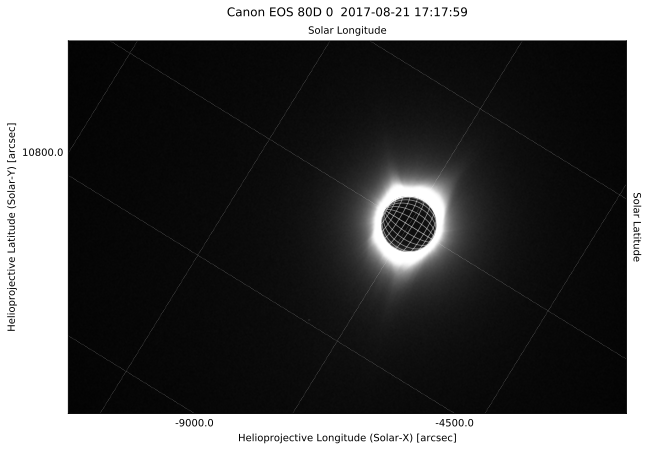

In [51]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [52]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s', distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [53]:
regulus

<SkyCoord (Helioprojective: obstime=2017-08-21 17:17:59, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21 17:17:59): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.92792462,   1.51325413e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-4500.27393523,  1509.20775772,   7.50236078e+14)>

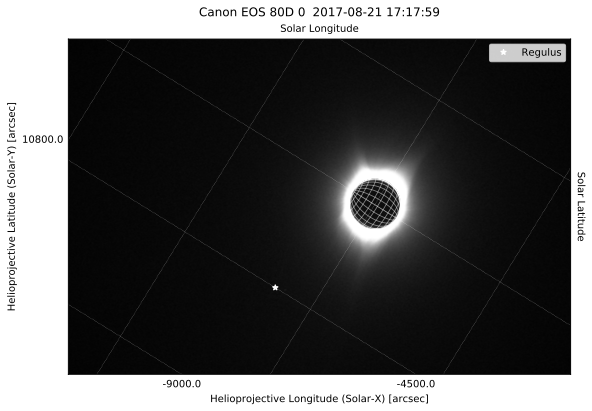

In [54]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, '*w', label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

We can see that the predicted location of regulus does not match which tells us that there a slight error in the angle. This is likely because the camera was not level with the horizon. Therefore we adjust to get it right.

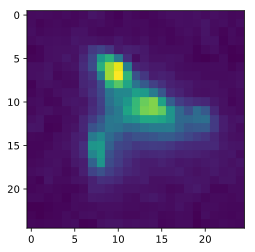

In [83]:
fudge_angle = -4.5 * u.deg # Van DSLR images.
#fudge_angle = 2.5 * u.deg # JCMO DSLR images.
#fudge_angle = -18. * u.deg # JCMO DSLR images.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
im1 = np.max(im) - im
im1[995:1020,2585:2610] = im1[995:1020,2585:2610]*(-0.00125*np.max(im1))/np.max(im1[995:1020,2585:2610])
m = sunpy.map.Map((im1, header))

plt.imshow(im1[995:1020,2585:2610])

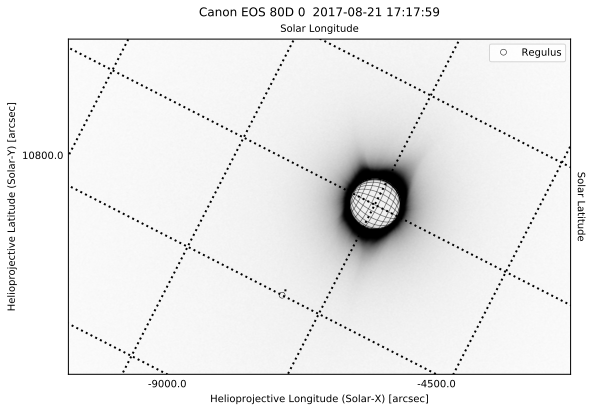

In [84]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, 'o', markeredgewidth=0.5, markeredgecolor='k', 
              markerfacecolor='None', label='Regulus')
m.draw_grid(axes=ax,color='k')
m.draw_limb(axes=ax,color='k')
plt.legend()
plt.savefig('Helioprojective_Braxton.pdf',format='pdf')
ax.coords.grid(color='black', alpha=1, linestyle='dotted',linewidth=2)
ax.set_facecolor('k')

plt.show()

More tweaking could be done here to get thing right. We will leave that as an exercise for the reader!

# Plot an SDO AIA Image of the Sun on your photo

First we need to download the images

In [85]:
from sunpy.net import Fido, attrs as a
# Replace the time below with the time in UT of the eclipse
t = a.Time('2017-08-21 17:17:00', "2017-08-21 17:18:13")
#t = a.Time('2017-08-21 17:50:13', "2017-08-21 17:55:13")
aia_result = Fido.search(t, a.Instrument('AIA'), a.Wavelength(171*u.Angstrom))
aia_result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2017-08-21 17:17:09,2017-08-21 17:17:10,SDO,AIA,FULLDISK,171.0 .. 171.0
2017-08-21 17:17:21,2017-08-21 17:17:22,SDO,AIA,FULLDISK,171.0 .. 171.0
2017-08-21 17:17:33,2017-08-21 17:17:34,SDO,AIA,FULLDISK,171.0 .. 171.0
2017-08-21 17:17:45,2017-08-21 17:17:46,SDO,AIA,FULLDISK,171.0 .. 171.0
2017-08-21 17:17:57,2017-08-21 17:17:58,SDO,AIA,FULLDISK,171.0 .. 171.0
2017-08-21 17:18:09,2017-08-21 17:18:10,SDO,AIA,FULLDISK,171.0 .. 171.0


In [86]:
files = Fido.fetch(aia_result[0,0])

[                                        ======================

In [87]:
files

['/home/oliveros/sunpy/data/aia_lev1_171a_2017_08_21t17_17_09_35z_image_lev1.fits']

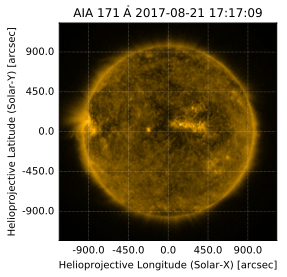

In [88]:
aia_map = sunpy.map.Map(files[0])
aia_map.plot()

To overplot the images we must align them, this can be done with `rotate`.

In [89]:
am2 = aia_map.rotate(rmatrix=np.linalg.inv(m.rotation_matrix),
                     recenter=True, order=3, scale=(aia_map.scale[0]/m.scale[0]))

/home/oliveros/anaconda3/lib/python3.6/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


We then must calculate the extent of the AIA image in terms of pixels in the eclipse image.

In [90]:
xmin, ymin = (u.Quantity(m.reference_pixel) - u.Quantity(am2.reference_pixel)).to_value(u.pix)

In [91]:
xmax = am2.data.shape[1] + xmin
ymax = am2.data.shape[0] + ymin

In [92]:
extent = (xmin, xmax, ymin, ymax)

Finally we mask out the pixels with a low value in the eclipse image (to make the disk transparent).

In [93]:
extent
#m.data[m.data < 30] = np.nan

(916.5, 6430.5, -723.5, 4790.5)

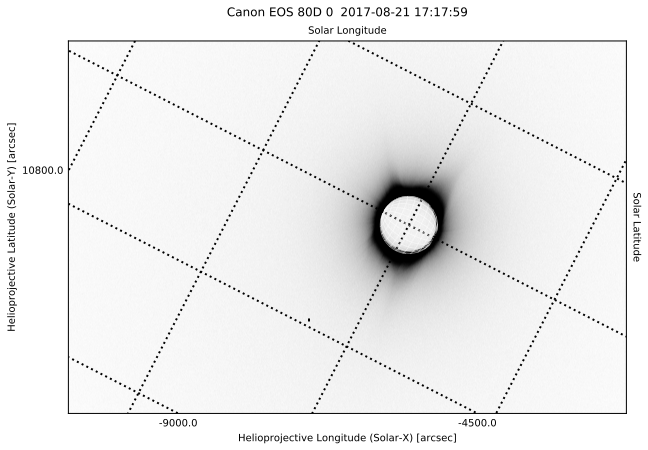

In [98]:
fig = plt.figure(figsize=(10,15))
ax = plt.subplot(projection=m)

# Set the axes background to black.
ax.set_facecolor('k')

# Plot the AIA image.
am2.plot(extent=extent)
# Plot the eclipse image
m.plot()

# Draw heliographic and helioprojective grids
m.draw_grid()
ax.coords.grid(color='black', alpha=1, linestyle='dotted',linewidth=2)